In this lecture, we focus on Python's ability for natural language processing (NLP). Our goal is to understand the basics of text mining and then perform a Naive Bayes classifier on the text to build a model. The focus here are two-folds: 1) We need to learn how to 'featurize' the text, i.e. how we can extract useful information from a text document, and 2) we need to learn how to build a machine learning model based on the underlying text data. This lecture only serves as a crash course for NLP. Further details can be found in more advanced books. There are three good sources of natural language processsing, all of which are listed in the reference sections:

1. Manning, Raghavan and Schuetze (2008), Introduction to Information Retrieval
2. Bird, Klein and Loper (2009), Natural Language Processing with Python-Analyzing Text with the Natural Language Toolkit
3. Jurafsky and Martin (2017), Speech and Language Processing

We first go over some important concepts in NLP. Then we gradually discuss techniques in Python. From a programmer's point of view. NLP is challenging in 2 aspects: 1) information retrieval (how can we extract all the useful information from the unstructered texts?) 2) machine learning altorithm (how can we leverage statistics and machine learning algorithms to study patterns?)

In [1]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import string

from collections import Counter
from nltk import word_tokenize
from nltk.corpus import gutenberg
from nltk.corpus import brown
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

%matplotlib inline

To start with, we all know that texts are built on strings, which can later form words, and sentences, and articles, and more. To organize all these concepts, we start our discussion with the concept of a corpus. A **corpus** is simply defined to be a large collection of texts. It is a body of written or spoken material upon which a linguistic analysis is based. The plural form of corpus is corpora. The point of defining a corpus is that we have a scope of the text data we can extract information from and perform linguistic or statistical analysis upon. 

The NLP package itself contains a sea of corpus. The nltk.download() command will help us navigate through varieties of corpora to download. Let's use one example here. Below displays some statistics for each text in a corpus: average word length, average sentence length, and the number of times each vocabulary item appears in the text on average (our lexical diversity score):

In [2]:
# nltk.download() # uncomment this if you have installed all the package

In [3]:
for fileid in gutenberg.fileids():
    num_chars = len(gutenberg.raw(fileid))
    num_words = len(gutenberg.words(fileid))
    num_sents = len(gutenberg.sents(fileid))
    num_vocab = len(set([w.lower() for w in gutenberg.words(fileid)]))
    print(num_chars/num_words, num_words/num_sents, num_words/num_vocab, fileid)

4.609909212324673 24.822884416924666 26.201933551198255 austen-emma.txt
4.749793727271801 26.19989324793168 16.82450728363325 austen-persuasion.txt
4.753785952421314 28.32086417283457 22.11088552241137 austen-sense.txt
4.286881563819072 33.57319868451649 79.16143181640166 bible-kjv.txt
4.567033756284415 19.073059360730593 5.442345276872964 blake-poems.txt
4.489300433741879 19.40726510653161 14.10228426395939 bryant-stories.txt
4.464641670621737 17.99146110056926 12.163566388710713 burgess-busterbrown.txt
4.233216065669891 20.029359953024077 12.940060698027315 carroll-alice.txt
4.716173862839705 20.296296296296298 11.637192561487703 chesterton-ball.txt
4.724783007796614 22.61245401996847 11.042211957916345 chesterton-brown.txt
4.63099417739442 18.496258685195084 10.901401795558355 chesterton-thursday.txt
4.4391184023772565 20.59266862170088 24.939386764531786 edgeworth-parents.txt
4.76571875515204 25.928919375683467 15.136614241773549 melville-moby_dick.txt
4.835734572682675 52.30956239

We now have seen a corpus, so we need learn to extract information from the text and convert the information possibly using numerals so that later we can do machine learning on the text. Let's start from the very basic information. Suppose we have a text document and it has two lines of words: 1) blue house, and 2) red house. Here, the simpliest information we can extract is the word count. Each word can be vectorized by a bunch of 0's and 1's. A document represented as a vector of word counts is called a **bag of words**. In this example, we can create a word vector [red,blue,house]. This way, the first line of words 'blue house' can be represented by [red,blue,house]=[0,1,1], whereas the second line of words can be represented by [red,blue,house]=[1,0,1]. Once we vectorize the text, we can define many concepts such as similarity of two line of words (e.g. using the cosine function). The idea here is very similar to what data scientists do in dealing with healthcare administrative data: suppose you have a dataset of inpatient encounters (one line per encounter) and each encounter is represented by a patient having a variety of diagnosis codes (in billing data, we can expect up to 99 diagnosis codes and 99 procedure codes etc.). What people usually do to extract features is to create flags for each diagnosis code and give it a 1 or 0. The point of the text featurization is to extract information and represent them in numeric values so that we can later apply machine learning models easily. 

In the bag of words model, there are a few metrics that go along easily with word count. For example, **term frequency** (TF) helps us understand the importance of the term in the document. Mathematically, for a generic term t and a document d, TF(t,d)= number of occurrences of term t in document d. Similarly, the **inverse document frequency** (IDF) measures the importance of the term in the corpus. Mathematically, for a specific term t in the corpus with total number of documents equal D, IDF(t,T,D)=log(D/T(t)), where T(t) represents the number of documents that contain the specific term t (T is essentially a frequency). We can also define the **term frequency-inverse document frequent** (TF-IDF) as the product of TF and IDF, which gives us a composite weight for each term in each document. There are different versions of TF. The definitions here we give is the most original one. The online manuscript 'An Introduction to Information Retrieval' has more details on this topic. We will skip the details for now. 

For now, let's see an example. In the NLTK package, the Brown Corpus was the first million-word electronic corpus of English, created in 1961 at Brown University. This corpus contains text from 500 sources, and the sources have been categorized by genre, such as news, editorial, and so on. This corpus is a convenient resource for studying systematic differences between genres, a kind of linguistic inquiry known as **stylistics**. Let's compare genres in their usage of modal verbs (modal verbs are words that include 'can', 'may', 'must' etc.). The first step is to produce the counts for a particular genre. Next, we will obtain counts for each genre of interest. We'll use NLTK's support for conditional frequency distributions:

In [4]:
print(brown.categories(), '\n') # looking at the categories (genres) in this corpus

news_text = brown.words(categories='news')
fdist = nltk.FreqDist([w.lower() for w in news_text])
modals = ['can', 'could', 'may', 'might', 'must', 'will']
print("Word counts in the 'news' cateogry of the Brown Corpus:")
for m in modals:
    print(m + ':', fdist[m])
    
cfd = nltk.ConditionalFreqDist(
    (genre, word.lower())
    for genre in brown.categories()
    for word in brown.words(categories=genre))
genres = ['news', 'religion', 'hobbies', 'science_fiction', 'romance', 'humor']
modals = ['can', 'could', 'may', 'might', 'must', 'will']
print('\n')
print('Conditional Frequencies for Different Genres:')
cfd.tabulate(conditions=genres, samples=modals)

['adventure', 'belles_lettres', 'editorial', 'fiction', 'government', 'hobbies', 'humor', 'learned', 'lore', 'mystery', 'news', 'religion', 'reviews', 'romance', 'science_fiction'] 

Word counts in the 'news' cateogry of the Brown Corpus:
can: 94
could: 87
may: 93
might: 38
must: 53
will: 389


Conditional Frequencies for Different Genres:
                  can could   may might  must  will 
           news    94    87    93    38    53   389 
       religion    84    59    79    12    54    72 
        hobbies   276    59   143    22    84   269 
science_fiction    16    49     4    12     8    17 
        romance    79   195    11    51    46    49 
          humor    17    33     8     8     9    13 


Having word count in our data matrix is useful, but we need more information certainly for bigger projects. In terms of linguistics, there are three important concepts that we often hear from NLP expert. First, given a character sequence and a defined document unit, **tokenization** is the task of chopping it up into pieces, called **tokens**, perhaps at the same time throwing away certain characters, such as punctuation. Here is an example: 

   * Input: Friends, Romans, Countrymen, lend me your ears!
   * Output: ['Friends', 'Romans', 'Countrymen', 'lend', 'me', 'your', 'ears']

The above tokenization example merely slices up the sentence and removes punctuations. These tokens are often loosely referred to as **terms or words**, but it is sometimes important to make a type/token distinction. A token is an instance of a sequence of characters in some particular document that are grouped together as a useful semantic unit for processing. A **type** is the class of all tokens containing the same character sequence. The major question of the tokenization phase is what are the correct tokens to use? In this example, it looks fairly trivial: you chop on whitespace and throw away punctuation characters. This is a starting point, but even for English there are a number of tricky cases. For example, what do you do about the various uses of the apostrophe for possession and contractions? In addition, different languages may require different tokenization strategies. Tokenization is always an interesting yet important topic for NLP practitioners. 

Second, a **lemma** (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words (headword). In English for example, the word 'run', 'runs', 'ran' and 'running'' are forms of the same **lexeme** (a unit of lexical meaning that exists regardless of the number of inflectional endings it may have or the number of words it may contain), with 'run' as the lemma. The process called **lemmatization** essentially helps us make our data more normalized in some way.
In computer linguistic literature, a related concept is **stemming**, which is the process of reducing inflected, or sometimes derived words, to their word stem, base or root form—generally a written word form. The stem need not be identical to the morphological root of the word; it is usually sufficient that related words map to the same stem, even if this stem is not in itself a valid root. In comparison, lemmatization is the algorithmic process of determining the lemma of a word based on its intended meaning. Unlike stemming, lemmatization depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document. As a result, developing efficient lemmatization algorithms is an open area of research. 

Essentially, stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word. For example, if confronted with the token 'saw', stemming might return just 's', whereas lemmatization would attempt to return either 'see' or 'saw' depending on whether the use of the token was as a verb or a noun. The two may also differ in that stemming most commonly collapses derivationally related words, whereas lemmatization commonly only collapses the different inflectional forms of a lemma. Linguistic processing for stemming or lemmatization is often done by an additional plug-in component to the indexing process, and a number of such components exist, both commercial and open-source.

The third concept is **part of speech**. In traditional grammar, a part of speech (sometimes abbreviated as PoS or POS) is a category of words (or, more generally, of lexical items) which have similar grammatical properties. Words that are assigned to the same part of speech generally display similar behavior in terms of syntax—they play similar roles within the grammatical structure of sentences—and sometimes in terms of morphology, in that they undergo inflection for similar properties. Commonly listed English parts of speech are noun, verb, adjective, adverb, pronoun, preposition, conjunction, interjection, and sometimes numeral, article or determiner.

We hare made some preparations from the theory perspective, now let's examine our dataset. In NLP, the datasets can come in many forms, so each file may require different techniques of data cleaning and feature extraction. Here, the file we are using contains a collection of more than 5 thousand SMS phone messages. The dataset we will be using is from the UCI dataset: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection.

In [5]:
os.chdir("C:\\Users\\pgao\\Documents\\PGZ Documents\\Programming Workshop\\PYTHON\\Open Courses on Python\\Udemy Course on Python\Introduction to Data Science Using Python\\datasets\\smsspamcollection")

In [6]:
data = [line.rstrip() for line in open('SMSSpamCollection')]
print(len(data))

5574


Let's print the first ten messages and number:

In [7]:
for message_no, message in enumerate(data[:10]):
    print(message_no, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim cod

Due to the spacing we can tell that this is a TSV (tab separated values) file, where the first column is a label saying whether the given message is a normal message (commonly known as 'ham') or a spam message (garbage text). The second column is the message itself. Using these labeled 'ham' and 'spam' examples, we'll need to train a machine learning model to learn to discriminate between ham/spam automatically. Then, with a trained model, we'll be able to classify arbitrary unlabeled messages as 'ham' or 'spam'.

Dealing with this type of data, the first step is to clean the data and transform the type of our data object into something familiar. Naturally, we think of 'pandas'.Let's try the following:

In [8]:
data = pd.read_csv('SMSSpamCollection', sep='\t', names=["label", "message"])
print(type(data))
data.head()

<class 'pandas.core.frame.DataFrame'>


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Here, we used the read_csv() and make note of the 'sep' argument. We can also specify the desired column names by passing in a list of 'names' (column names) so that we have a complete 'DataFrame' object. Now let's do some explorative analyses:

In [9]:
data.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [10]:
data.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Let's see how balanced is this data (i.e., is the data very sparse?):

In [11]:
dict(Counter(data.label))

{'ham': 4825, 'spam': 747}

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of **feature engineering**. Feature engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data. In general, the better your domain knowledge on the data, the better your ability to engineer more features from it.

Let's start by making a new column to detect how long the text messages are:

In [12]:
data['length'] = data['message'].apply(len)
print('message lengths description: \n')
print(data.length.describe()) 
data.head()

message lengths description: 

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64


,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


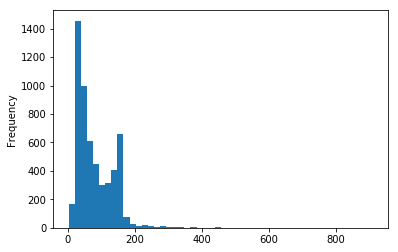

In [13]:
data['length'].plot(bins=50, kind='hist') 

Based on the distribution, we see that there are tons of messages that are ultra long, let's find one of them:

In [14]:
data[data['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

It looks like we have some sort of Romeo sending texts! But let's focus back on the idea of trying to see if message length is a distinguishing feature between 'ham' and 'spam'. What the picture belwo tells us is that the message length is possibly a very good feature to detect spams, as spams tend to be characterized with longer word length. In fact, our visualization confirms our conjecture:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001BF204E27B8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001BF2055B860>], dtype=object)

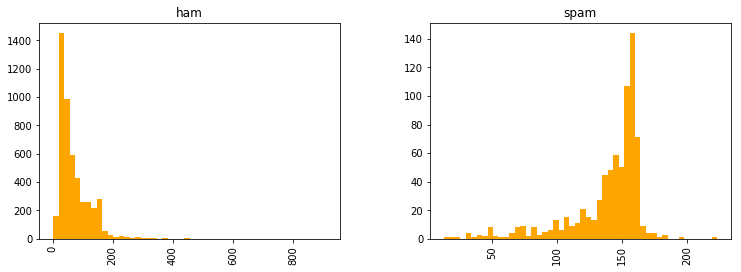

In [15]:
data.hist(column='length', by='label', bins=50,figsize=(12,4), color='orange')

We have successfully engineered one feature so far, which is likely to be very useful when it comes to classification tasks later. We now need to keep up with the good momentum. Nevertheless, we have not dug deep into the text itself. If we can extract more information from the text, then we will have another set of features created for later use of machine learning tasks. There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number. To do so, intuitively speaking, we will need to write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc.) and then obtain our features. To implement all these, let's create a function that will process the string in the message column, then we can just use the apply() function in 'pandas' do process all the text in the 'DataFrame object consistently across texts. In this exercise, we will 1) remove all the punctuations. 2) Remove all the **stopwords** (e.g. me, myself, ours, our, yours etc.). 

First let's get rid of punctuation. We can just take advantage of Python's built-in 'string' library to get a quick list of all the possible punctuation. Below is an example:

In [16]:
test_mess = 'Sample message! Notice: it has punctuation.'

nopunc = [char for char in test_mess if char not in string.punctuation] # checking characters to see if they are in punctuation
nopunc = ''.join(nopunc) # joining the characters again to form the string
nopunc

'Sample message Notice it has punctuation'

Next, let's see how to remove stopwords. We can import a list of English stopwords from NLTK. Below, let's show some stopwords to an idea about what stopwords should like like. There are currently 179 stopwords defined in the package. These need to be removed from our texts:

In [17]:
print('Some Examples of stopwords:')
print(stopwords.words('english')[100:120], '\n')
print(len(stopwords.words('english')))
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
clean_mess

Some Examples of stopwords:
['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only'] 

179


['Sample', 'message', 'Notice', 'punctuation']

Now let's put both of these together in a function to apply it to our DataFrame later on: 

In [18]:
def simple_text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation.
    2. Remove all stopwords.
    3. Returns a list of the cleaned text.
    """
    nopunc = [char for char in mess if char not in string.punctuation] # checking characters to see if they are in punctuation
    nopunc = ''.join(nopunc) # joining the characcters again to form the string
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')] # removing stopwords

To see the effect of this function, let's apply the function to the first 5 records of our dataset and then compare it with the original message:

In [19]:
data['message'].head(5).apply(simple_text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [20]:
print('original message:')
data.head()

original message:


,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [21]:
data['message2']=data['message'].apply(simple_text_process)
data.head()

,label,message,length,message2
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, jurong, point, crazy, Available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar, Joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin..."
3,ham,U dun say so early hor... U c already then say...,49,"[U, dun, say, early, hor, U, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, dont, think, goes, usf, lives, around, t..."


Now let's be more sophisticated. For grammatical reasons, we all know that documents are going to use different forms of a word, such as 'organize', 'organizes', and 'organizing'. Additionally, there are families of derivationally related words with similar meanings, such as 'democracy', 'democratic', and 'democratization'. In many situations, it seems as if it would be useful for a search for one of these words to return documents that contain another word in the set.

The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form, and from a machine learning standpoint, both stemming and lemmatization helps us with dimensionality reduction. For example, if we see a list of words ['is', 'was', 'been'], we want to reduce it to ['be']. If we have ["car", "cars", "cars'"], we want to collapse it into ['car']. 

There are many algorithms for stemming and lemmatization. Both stemming and lemmatizationn are constantly used in conjunction with regular expressions, which we will not cover here in detail. NLTK includes several off-the-shelf stemmers, and if you ever need a stemmer you should use one of these in preference to crafting your own using regular expressions, since these handle a wide range of irregular cases. The Porter and Lancaster stemmers follow their own rules for stripping affixes. In contrast, the 'WordNet' lemmatizer only removes affixes if the resulting word is in its dictionary. Below are some examples:

In [22]:
raw = """DENNIS: Listen, strange women lying in ponds distributing swords
... is no basis for a system of government.  Supreme executive power derives from
... a mandate from the masses, not from some farcical aquatic ceremony."""
tokens = word_tokenize(raw)
print('Raw Tokens:\n', tokens)
print('\n')
porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()
wnl = nltk.WordNetLemmatizer()
print('Using Porter Stemmer:\n', [porter.stem(t) for t in tokens])
print('\n')
print('Using Lancaster Stemmer:\n', [lancaster.stem(t) for t in tokens])
print('\n')
print('Using Lemmatization:\n', [wnl.lemmatize(t) for t in tokens])

Raw Tokens:
 ['DENNIS', ':', 'Listen', ',', 'strange', 'women', 'lying', 'in', 'ponds', 'distributing', 'swords', 'is', 'no', 'basis', 'for', 'a', 'system', 'of', 'government', '.', 'Supreme', 'executive', 'power', 'derives', 'from', 'a', 'mandate', 'from', 'the', 'masses', ',', 'not', 'from', 'some', 'farcical', 'aquatic', 'ceremony', '.']


Using Porter Stemmer:
 ['denni', ':', 'listen', ',', 'strang', 'women', 'lie', 'in', 'pond', 'distribut', 'sword', 'is', 'no', 'basi', 'for', 'a', 'system', 'of', 'govern', '.', 'suprem', 'execut', 'power', 'deriv', 'from', 'a', 'mandat', 'from', 'the', 'mass', ',', 'not', 'from', 'some', 'farcic', 'aquat', 'ceremoni', '.']


Using Lancaster Stemmer:
 ['den', ':', 'list', ',', 'strange', 'wom', 'lying', 'in', 'pond', 'distribut', 'sword', 'is', 'no', 'bas', 'for', 'a', 'system', 'of', 'govern', '.', 'suprem', 'execut', 'pow', 'der', 'from', 'a', 'mand', 'from', 'the', 'mass', ',', 'not', 'from', 'som', 'farc', 'aqu', 'ceremony', '.']


Using Lemma

For most of the time, lemmatization is more superior to stemming as we have discussed previously. For this project, we will pick lemmatization as our primary approach and then we will apply it to the messages in our data:

In [34]:
def simple_text_process2(mess):
        wnl = nltk.WordNetLemmatizer()
        return [wnl.lemmatize(t) for t in mess] 

data['message3']=data['message2'].apply(simple_text_process2)
data.head(10)

,label,message,length,message2,message3
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, jurong, point, crazy, Available, bugis, n...","[Go, jurong, point, crazy, Available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar, Joking, wif, u, oni]","[Ok, lar, Joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin...","[Free, entry, 2, wkly, comp, win, FA, Cup, fin..."
3,ham,U dun say so early hor... U c already then say...,49,"[U, dun, say, early, hor, U, c, already, say]","[U, dun, say, early, hor, U, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, dont, think, goes, usf, lives, around, t...","[Nah, dont, think, go, usf, life, around, though]"
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147,"[FreeMsg, Hey, darling, 3, weeks, word, back, ...","[FreeMsg, Hey, darling, 3, week, word, back, I..."
6,ham,Even my brother is not like to speak with me. ...,77,"[Even, brother, like, speak, treat, like, aids...","[Even, brother, like, speak, treat, like, aid,..."
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160,"[per, request, Melle, Melle, Oru, Minnaminungi...","[per, request, Melle, Melle, Oru, Minnaminungi..."
8,spam,WINNER!! As a valued network customer you have...,157,"[WINNER, valued, network, customer, selected, ...","[WINNER, valued, network, customer, selected, ..."
9,spam,Had your mobile 11 months or more? U R entitle...,154,"[mobile, 11, months, U, R, entitled, Update, l...","[mobile, 11, month, U, R, entitled, Update, la..."


Now we have a more organized and 'cleaner' version of our data, let's perform vectorization. We'll do that in three steps using the bag-of-words model (there are many other ways of course, but here we will only cover this model for illustrative purposes):

1. Count how many times does a word occur in each message (term frequency).

2. Weigh the counts, so that frequent tokens get lower weight (using inverse document frequency).

3. Normalize the vectors to unit length, to abstract from the original text length (using the L2 norm).

Let's begin the first step. Notice that each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use the CountVectorizer() function to convert a collection of text documents to a matrix of token counts. We can imagine this as a 2-dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Textstring 1</th> <th>Textstring 2</th> <th>...</th> <th>Textstring N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word M Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>

Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, the library will output a sparse matrix. 

In [24]:
bow_transformer = CountVectorizer(analyzer=simple_text_process2).fit(data['message3'])
print(len(bow_transformer.vocabulary_)) # printing total number of vocab words

10943


Now let's do this step by step. Let's take one random text message (the 107th message) and get its bag-of-words counts as a vector, putting to use our new bow_transformer() and then see the result from vectorization:

In [25]:
datacheck = data['message3'][106]
print(datacheck)
bowcheck= bow_transformer.transform([datacheck])
print(bowcheck)
print(bowcheck.shape)

['Thanks', 'lot', 'wish', 'birthday', 'Thanks', 'making', 'birthday', 'truly', 'memorable']
  (0, 3953)	2
  (0, 5016)	2
  (0, 7668)	1
  (0, 7771)	1
  (0, 7867)	1
  (0, 10207)	1
  (0, 10630)	1
(1, 10943)


The above result implies that there are 7 unique words in this particular message (after removing common stopwords). Two of them appear twice, the rest only once. Let's go ahead and check and confirm which ones appear twice:

In [26]:
print(bow_transformer.get_feature_names()[3953])
print(bow_transformer.get_feature_names()[5016])

Thanks
birthday


Now let's perform this on the entire dataset and calculate the sparsity metric of the matrix (a non-negative real number). If sparsity=0, then it's a bad sign. The further away sparsity is from 0, the better because that indicates we have quite a dense dataset:

In [35]:
messages_bow = bow_transformer.transform(data['message3'])
print('Object type: ', type(messages_bow))
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])) # nnz stands for non-zero
print('sparsity: {}'.format(sparsity)) # this really just tells you how many non-zero entries are there in the entire matrix

Object type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape of Sparse Matrix:  (5572, 10943)
Amount of Non-Zero occurences:  50458
sparsity: 0.08275276724348364


Now let's apply the concepts of TF and IDF in our model and explore them in more details. Recall that the TF measure computes how frequently a term occurs in a document, that is, the number of times a word appears in a document. Sometimes. People define TF in its normalized version (normalized term frequency, a.k.a NTF): NTF(t,d)=number of occurrences of term t in document d/len(d), where len(d) denotes the total number of words in that document. The rationale for the division is that since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length as a way of normalization. The IDF is computed as the logarithm of the total number of the documents in the corpus divided by the number of documents where the specific term appears. It really intends to measure how important a term is. The rationale is that while computing the term frequency, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones. Finally, the TF-IDF weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the TF-IDF weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query. In simple terms, TF-IDF=(TF)(IDF). If TF is defined in the normalized version, then TF-IDF=(NTF)(IDF). Let's see an empirical example below below:

Consider a document (d) containing 100 words wherein the term (t) 'cat' appears 3 times. The normalized term frequency for cat is then TF=(3/100) = 0.03. Now, assume we have 90 documents (D=90) and the word 'cat' appears in one 1000 of these. Then, the inverse document frequency (IDF) is calculated as IDF=log(D/T(t))=log(90/1000)=log(0.09). 

Now let's implement these in Python. Below, the TfidfTransformer() function transform a count matrix to a normalized TF or TF-IDF representation. When we use the argument combination (use_idf=False, smooth_idf=False, norm=None), we get a matrix of TF, whereas if we use (use_idf=True, smooth_idf=False, norm=None), we get a matrix of TF-IDF. Let's create two instances and compare them:

In [36]:
tf_transformer= TfidfTransformer(use_idf=False, smooth_idf=False, norm=None).fit(messages_bow) # creating an instance and getting the TF vectors
tfidf_transformer = TfidfTransformer(use_idf=True, smooth_idf=False, norm=None).fit(messages_bow) # creating an instance and getting the IDF vectors 
data_tf=tf_transformer.transform(messages_bow) # transforming the entire bag-of-words corpus into NTF corpus at once
data_tfidf = tfidf_transformer.transform(messages_bow) # transforming the entire bag-of-words corpus into TF-IDF corpus at once  
print(data_tf.shape)
print(data_tfidf.shape)
print(type(data_tf))
print(type(data_tfidf))

(5572, 10943)
(5572, 10943)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In general, the arguments in the TfidfTransformer() functions are very versatile. In the above example, we are simply getting the matrix for the raw TF and TF-IDF. If the argument smooth_idf is set to be 'True', the constant '1' is added to the numerator and denominator of the IDF as if an extra document was seen containing every term in the collection exactly once, which prevents zero divisions. In this case, the IDF is computed as log[(D+1)/(1+T(t))]+1. Most of the machine learning models requires some type of normalization. But here, for simplicity and validation purposes, we will use all metrics with no normalization. This will help us validate our existing numbers and understand the intuition better. More details about these arguments can be found in the online official documentation. Now let's check some examples for validation purposes:

In [29]:
tfcheck = tf_transformer.transform(bowcheck)
print('Raw TF matrix (not normalized) for the 107th message:')
print(tfcheck)
tfidfcheck = tfidf_transformer.transform(bowcheck)
print('TF-IDF matrix for (with no normalization) the 107th message:')
print(tfidfcheck)
print("IDF for the word 'birthday': ", tfidf_transformer.idf_[bow_transformer.vocabulary_['birthday']])
print("IDF for the word 'birthday': ", tfidf_transformer.idf_[bow_transformer.vocabulary_['Thanks']])

Raw TF matrix (not normalized) for the 107th message:
  (0, 3953)	2.0
  (0, 5016)	2.0
  (0, 7668)	1.0
  (0, 7771)	1.0
  (0, 7867)	1.0
  (0, 10207)	1.0
  (0, 10630)	1.0
TF-IDF matrix for (with no normalization) the 107th message:
  (0, 10630)	5.9119372682
  (0, 10207)	8.01607142247
  (0, 7867)	9.6255093349
  (0, 7771)	6.58098689718
  (0, 7668)	5.77536173319
  (0, 5016)	13.0689337631
  (0, 3953)	11.5507234664
IDF for the word 'birthday':  6.53446688154
IDF for the word 'birthday':  5.77536173319


We now have obtained a good training dataset called 'data_tfidf'. With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. Here, we will choose the naive Bayes classifier algorithm. The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as TF-IDF may also work.

In [30]:
spam_detect_model = MultinomialNB().fit(X=data_tfidf, y=data['label'])

In [31]:
print(data_tfidf.data.shape)
print(data.shape)

(50458,)
(5572, 5)


Let's try classifying our single random message and checking how we do:

In [37]:
print('predicted:', spam_detect_model.predict(tfidfcheck)[0])
print('expected:', data.label[106]) # checking how the prediction is doing

predicted: ham
expected: ham


Now we want to determine how well our model will do overall on the entire dataset. Here, for illustrative purposes, let's skip the step of splitting the data into test dataset and training dataset. Let's just get the prediction. Keep in mind that in real world problems, we need to do the train-test split first prior to all of the codes above. The split must happen at the beginnning of the code. Here we are just showing the result as an example to demonstrate how the code works and how things tie together eventually.

In [33]:
yhat = spam_detect_model.predict(data_tfidf)
print(yhat)
print(classification_report(data['label'], yhat))

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham']
             precision    recall  f1-score   support

        ham       1.00      0.99      1.00      4825
       spam       0.96      0.99      0.98       747

avg / total       0.99      0.99      0.99      5572



NLTK is a big topic in Python and because of the complexity of each step during the training and testing phase, so people have built a pipline for this type of project in the 'sklearn' library. We will not elaborate here, but the following command will import that library:

    - from sklearn.pipeline import Pipeline
    
This way, we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API. We will omit the details here but the online documentation certainly have more details. 

References:
   - https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/
   - https://nlp.stanford.edu/IR-book/html/htmledition/contents-1.html 
   - http://www.nltk.org/book/
   - http://scikit-learn.org/stable/modules/pipeline.html
   - http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer.transform